In [1]:
# Getting Data

! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
from google.colab import drive
drive.mount('/content/drive') 

Mounted at /content/drive


In [3]:
! mkdir ~/.kaggle

In [5]:
!cp /content/drive/MyDrive/Kaggle_API_Credentials/kaggle.json ~/.kaggle/kaggle.json

In [6]:
! chmod 600 ~/.kaggle/kaggle.json

In [7]:
!kaggle datasets download mahmoudima/mma-facial-expression

 86% 142M/166M [00:01<00:00, 94.9MB/s]
100% 166M/166M [00:01<00:00, 90.1MB/s]


In [8]:
! unzip /content/mma-facial-expression.zip

Streaming output truncated to the last 5000 lines.
  inflating: MMAFEDB/valid/neutral/8867Exp6fighting_expression_295.jpg  
  inflating: MMAFEDB/valid/neutral/8870Exp6fighting_expression_308.jpg  
  inflating: MMAFEDB/valid/neutral/8871Exp6fighting_expression_308.jpg  
  inflating: MMAFEDB/valid/neutral/8872Exp6fighting_expression_320.jpg  
  inflating: MMAFEDB/valid/neutral/8873Exp6fighting_expression_326.jpg  
  inflating: MMAFEDB/valid/neutral/8875Exp6fighting_expression_342.jpg  
  inflating: MMAFEDB/valid/neutral/8876Exp6fighting_expression_346.jpg  
  inflating: MMAFEDB/valid/neutral/8878Exp6fighting_expression_395.jpg  
  inflating: MMAFEDB/valid/neutral/8880Exp6fighting_expression_413.jpg  
  inflating: MMAFEDB/valid/neutral/8881Exp6fighting_expression_45.jpg  
  inflating: MMAFEDB/valid/neutral/8882Exp6fighting_expression_46.jpg  
  inflating: MMAFEDB/valid/neutral/8887Exp6fighting_expression_578.jpg  
  inflating: MMAFEDB/valid/neutral/8888Exp6fighting_expression_58.jpg  
  i

In [1]:
import os
import cv2
import numpy as np
from tqdm import tqdm

In [8]:
global Output_labels
Output_labels = ['Angry','Disgust','Fear','Happy','Neutral','Sad','Surprise']

In [9]:
REBUILD_DATA = True # set to true to one once, then back to false unless you want to change something in your training data.

class FacialExpressions():
    IMG_SIZE = 224
    
    TESTING = "PetImages/Testing"
    Angry = 'train/angry'
    Disgust = 'train/disgust'
    Fear = 'train/fear'
    Happy = 'train/happy'
    Neutral = 'train/neutral'
    Sad = 'train/sad'
    Surprise = 'train/surprise'
    la = [Angry,Disgust,Fear,Happy,Neutral,Sad,Surprise]

    LABELS = {Angry:0, Disgust:1, Fear:2, Happy:3, Neutral:4, Sad:5, Surprise:6}
    training_data = []

    count = np.zeros(7)

    def make_training_data(self):
        i = -1
        for label in self.LABELS:
            i+=1

            temp = []
            print(label)
            for f in tqdm(os.listdir(label)):

                if "jpg" in f:
                    try:
                        path = os.path.join(label, f)
                        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                        img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                        temp.append([np.array(img), np.eye(7)[self.LABELS[label]]])  # do something like print(np.eye(2)[1]), just makes one_hot 
                        #print(np.eye(2)[self.LABELS[label]])

                        

                    except Exception as e:
                        pass
                        #print(label, f, str(e))
            np.random.shuffle(temp)
            if len(temp)>5000:
                  temp = temp[:5000]
            self.count[i] = len(temp)
            self.training_data.extend(temp)

        np.random.shuffle(self.training_data)
        for _ in range(len(self.la)):
          print(f'{Output_labels[_]}: ', self.count[_] )

        return self.training_data
    



if REBUILD_DATA:
    face_expressions = FacialExpressions()
    training_data = face_expressions.make_training_data()

train/angry


100%|██████████| 6566/6566 [00:01<00:00, 5608.30it/s]


train/disgust


100%|██████████| 3231/3231 [00:00<00:00, 5469.06it/s]


train/fear


100%|██████████| 4859/4859 [00:00<00:00, 5425.38it/s]


train/happy


100%|██████████| 28592/28592 [00:06<00:00, 4416.91it/s]


train/neutral


100%|██████████| 29384/29384 [00:06<00:00, 4714.99it/s]


train/sad


100%|██████████| 12223/12223 [00:02<00:00, 5369.98it/s]


train/surprise


100%|██████████| 8113/8113 [00:01<00:00, 5172.62it/s]

Angry:  5000.0
Disgust:  3231.0
Fear:  4859.0
Happy:  5000.0
Neutral:  5000.0
Sad:  5000.0
Surprise:  5000.0


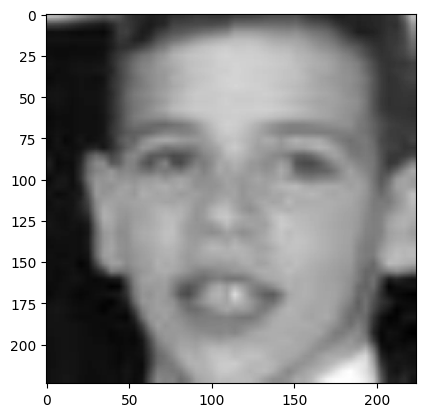

In [10]:
import matplotlib.pyplot as plt


plt.imshow(training_data[1][0], cmap='gray')
plt.show()

In [11]:
import torch
import torchvision
from torchvision import datasets,transforms
import torch.nn as nn
import torch.nn.functional as F

In [12]:
class Net(nn.Module):
    def __init__(self):
        super().__init__() # just run the init of parent class (nn.Module)
        self.conv1 = nn.Conv2d(1, 64, 7, padding=3, stride=2) # input is 1 image, 64 output channels, 7x7 kernel / window
        self.conv2a = nn.Conv2d(64, 96, 1, stride=1, padding=0)
        self.conv2b = nn.Conv2d(96, 208, 3, stride=1, padding=1) 
        self.conv2c = nn.Conv2d(64, 64, 1, stride=1, padding=0)
        self.conv3a = nn.Conv2d(272, 96, 1, stride=1, padding=0)
        self.conv3b = nn.Conv2d(96, 208, 3, stride=1, padding=1)
        self.conv3c = nn.Conv2d(272, 64, 1, stride=1, padding=0)
        


        x = torch.randn(224,224).view(-1,1,224,224)
        self._to_linear = None
        self.convs(x)

        self.fc1 = nn.Linear(self._to_linear, 512) #flattening.
        self.fc2 = nn.Linear(512, 7) # 512 in, 2 out bc we're doing 2 classes (dog vs cat).

    def convs(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, (3, 3), stride=2, padding=0)
        x = nn.LocalResponseNorm(2)(x)

        #FeatEx1
        x1 = x
        x1 = F.max_pool2d(x1, (3, 3), stride=1, padding=1)
        x1 = F.relu(self.conv2c(x1))
        x = F.relu(self.conv2a(x))
        x = F.relu(self.conv2b(x))
        x = torch.cat((x,x1),1)
        x = F.max_pool2d(x, (3,3), stride=2, padding=0)

        #FeatEx2
        x2 = x
        x2 = F.max_pool2d(x2, (3, 3), stride=1, padding=1)
        x2 = F.relu(self.conv3c(x2))
        x = F.relu(self.conv3a(x))
        x = F.relu(self.conv3b(x))

        x = torch.cat((x,x2),1)
        x = F.max_pool2d(x, (3,3), stride=2, padding=0)
        if self._to_linear is None:
                self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
        
        return x

    def forward(self,x):
        x = self.convs(x)
        x = x.view(-1,self._to_linear)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)



    #     x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
    #     x = F.max_pool2d(F.relu(self.conv3(x)), (2, 2))

    #     if self._to_linear is None:
    #         self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
    #     return x

    # def forward(self, x):
    #     x = self.convs(x)
    #     x = x.view(-1, self._to_linear)  # .view is reshape ... this flattens X before 
    #     x = F.relu(self.fc1(x))
    #     x = self.fc2(x) # bc this is our output layer. No activation here.
    #     return F.softmax(x, dim=1)


net = Net()

In [11]:
import torch.optim as optim

optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.MSELoss()

X = torch.Tensor([i[0] for i in training_data]).view(-1,224,224)
X = X/255.0
y = torch.Tensor([i[1] for i in training_data])

VAL_PCT = 0.1

val_size = int(len(X)*VAL_PCT)
print(val_size)

/var/folders/ct/kcvr8z_n361cb4kp_z0mhbjm0000gn/T/ipykernel_8339/1241263527.py:6: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:233.)
  X = torch.Tensor([i[0] for i in training_data]).view(-1,224,224)


3309


In [12]:
BATCH_SIZE = 100
EPOCHS = 15

for epoch in range(EPOCHS):
    for i in tqdm(range(0, len(X), BATCH_SIZE)): # from 0, to the len of x, stepping BATCH_SIZE at a time. [:50] ..for now just to dev
        #print(f"{i}:{i+BATCH_SIZE}")
        batch_X = X[i:i+BATCH_SIZE].view(-1, 1, 224,224)
        batch_y = y[i:i+BATCH_SIZE]

        net.zero_grad()

        outputs = net(batch_X)
        loss = loss_function(outputs, batch_y)
        loss.backward()
        optimizer.step()    # Does the update

    print(f"Epoch: {epoch}. Loss: {loss}")

100%|██████████| 331/331 [27:34<00:00,  5.00s/it]


Epoch: 0. Loss: 0.1160496398806572


100%|██████████| 331/331 [2:56:35<00:00, 32.01s/it]    


Epoch: 1. Loss: 0.11164528131484985


100%|██████████| 331/331 [3:48:10<00:00, 41.36s/it]    


Epoch: 2. Loss: 0.11063910275697708


100%|██████████| 331/331 [29:13<00:00,  5.30s/it]


Epoch: 3. Loss: 0.10886336863040924


100%|██████████| 331/331 [32:00<00:00,  5.80s/it]


Epoch: 4. Loss: 0.10289373248815536


100%|██████████| 331/331 [51:02<00:00,  9.25s/it]    


Epoch: 5. Loss: 0.09268927574157715


100%|██████████| 331/331 [28:32<00:00,  5.18s/it]


Epoch: 6. Loss: 0.08311828225851059


100%|██████████| 331/331 [30:10<00:00,  5.47s/it]


Epoch: 7. Loss: 0.08324482291936874


100%|██████████| 331/331 [48:31<00:00,  8.80s/it]   


Epoch: 8. Loss: 0.0859658271074295


  7%|▋         | 24/331 [02:26<28:33,  5.58s/it]

In [ ]:
a = [1,2,3]
b = [3,4,5]
a.extend(b)

In [ ]:
a.index(3)

2

In [3]:
torch.save(net, 'expression_half2.pkl')

NameError: name 'net' is not defined

In [17]:
IMG_SIZE = 224
    
TESTING = "PetImages/Testing"
Angry = 'test/angry'
Disgust = 'test/disgust'
Fear = 'test/fear'
Happy = 'test/happy'
Neutral = 'test/neutral'
Sad = 'test/sad'
Surprise = 'test/surprise'
la = [Angry,Disgust,Fear,Happy,Neutral,Sad,Surprise]
LABELS = {Angry:0, Disgust:1, Fear:2, Happy:3, Neutral:4, Sad:5, Surprise:6}




def make_testing_data():
    
    testing_data = []
    for label in LABELS:
        temp = []
        
        print(label)
        for f in tqdm(os.listdir(label)):
            if "jpg" in f:
                try:
                    path = os.path.join(label, f)
                    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
                    temp.append([np.array(img), np.eye(7)[LABELS[label]]])  # do something like print(np.eye(2)[1]), just makes one_hot 
                    #print(np.eye(2)[self.LABELS[label]])
                    
                except Exception as e:
                    pass
                    #print(label, f, str(e))
        np.random.shuffle(temp)
    
        testing_data.extend(temp)
    np.random.shuffle(training_data)
  
    return testing_data

test_data = make_testing_data()



test/angry


100%|██████████| 1041/1041 [00:00<00:00, 5673.09it/s]


test/disgust


100%|██████████| 655/655 [00:00<00:00, 5795.50it/s]


test/fear


100%|██████████| 691/691 [00:00<00:00, 6099.54it/s]


test/happy


100%|██████████| 5459/5459 [00:01<00:00, 4916.68it/s]


test/neutral


100%|██████████| 5858/5858 [00:01<00:00, 4515.54it/s]


test/sad


100%|██████████| 2177/2177 [00:00<00:00, 3931.65it/s]


test/surprise


100%|██████████| 1475/1475 [00:00<00:00, 4193.40it/s]


In [18]:
test_X = torch.Tensor([i[0] for i in test_data]).view(-1,224,224)

test_y = torch.Tensor([i[1] for i in test_data])

/var/folders/ct/kcvr8z_n361cb4kp_z0mhbjm0000gn/T/ipykernel_1156/2197277765.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:233.)
  test_X = torch.Tensor([i[0] for i in test_data]).view(-1,224,224)


In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for i in tqdm(range(len(test_X))):
        real_class = torch.argmax(test_y[i])
        net_out = net(test_X[i].view(-1,1,224,224))[0]
        predicted_class = torch.argmax(net_out)
        if predicted_class == real_class:
            correct+=1
        total+=1

print('Accuracy: ', round(correct/total,3))

100%|██████████| 17356/17356 [04:13<00:00, 68.51it/s]

Accuracy:  0.233


In [13]:
model = torch.load('expression_half.pkl')

In [39]:
model(test_X[33].view(-1,1,224,224))

tensor([[4.6318e-22, 3.4032e-32, 1.0000e+00, 7.8532e-17, 7.4786e-37, 1.0996e-14,
         1.2956e-22]], grad_fn=<SoftmaxBackward0>)

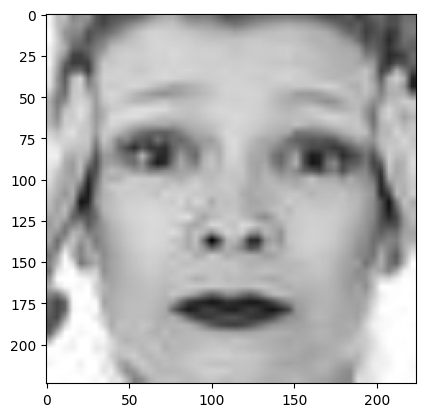

In [37]:
import matplotlib.pyplot as plt


plt.imshow(test_X[31], cmap='gray')
plt.show()

In [35]:
test_y[30]

tensor([1., 0., 0., 0., 0., 0., 0.])